<a href="https://colab.research.google.com/github/hakidaova/MLF/blob/main/MLF_cv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MKA-MLF, Lab_08 - RNN

Recurrent Neural Networks, are a class of artificial neural networks designed to recognize patterns in sequences of data, such as text, genomes, handwriting, or spoken words. Unlike traditional neural networks, which assume all inputs (and outputs) are independent of each other, RNNs are designed to recognize sequential or temporal patterns, making them especially suited for tasks like language modeling, speech recognition, and time series prediction.

## Exercise 1 - Time Series Forecasting

### 1.0 Import Libraries

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### 1.1 Generating dataset

In [110]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0,1,n_steps)

  series = 0.5 * np.sin((time - offsets1) * (freq1*10 + 10)) # sinusoid 1
  series += 0.2 * np.sin((time - offsets2) * (freq2*20 + 20)) # sinusoid 2
  series += 0.1 * (np.random.rand(batch_size, n_steps)- 0.5) # noise
  return series[..., np.newaxis].astype(np.float32)

In [111]:
data_size = 10000
n_steps = 50
np.random.seed(0)

series = generate_time_series(data_size, n_steps + 1)

### 1.2 Train/Valid/Test split

In [112]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [113]:
no_training_epochs = 5

### 1.3 Data examination

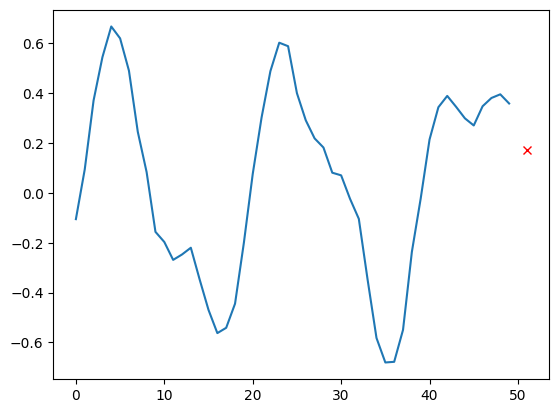

In [114]:
plt.figure()
plt.plot(X_train[0])
plt.plot(n_steps+1, y_train[0], 'rx')

### 1.4 Simple Linear model

In [115]:
# Model definition
model_linear = Sequential()
model_linear.add(Flatten(input_shape=(50,1)))
model_linear.add(Dense(1, activation = None))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [116]:
# Model building

learning_rate = 0.001
optimizer = Adam(learning_rate)
model_linear.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

In [117]:
model_linear.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

In [118]:
# Model training

history_linear = model_linear.fit(X_train, y_train, epochs=no_training_epochs, validation_data=[X_valid, y_valid])

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3466 - mean_squared_error: 0.3466 - val_loss: 0.0805 - val_mean_squared_error: 0.0805
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0402 - val_mean_squared_error: 0.0402
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0136 - val_mean_squared_error: 0.0136


In [119]:
def plot_function(history):
  plt.figure()

  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='validation_loss')
  plt.legend()
  plt.grid()
  plt.xlim([0,no_training_epochs-1])
  plt.xlabel('epochs')

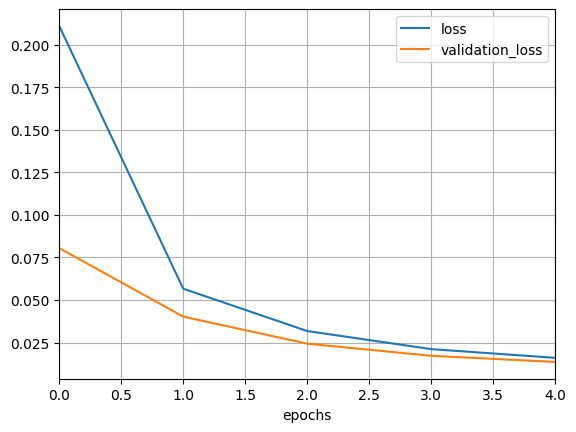

In [120]:
plot_function(history_linear)

In [121]:
score = model_linear.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test MSE: ', score[1])

Test loss: 0.01302032545208931
Test MSE:  0.01302032545208931


### 1.5 Simple RNN Model

In [122]:
model_simple_rnn = Sequential()
model_simple_rnn.add(SimpleRNN(1, input_shape=[50, 1]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [123]:
learning_rate_simple_rnn = 0.001
optimizer_simple_rnn = Adam(learning_rate_simple_rnn)
model_simple_rnn.compile(loss='mean_squared_error', optimizer=optimizer_simple_rnn, metrics=['mean_squared_error'])

In [124]:
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=no_training_epochs, validation_data=[X_valid, y_valid])

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6259 - mean_squared_error: 0.6259 - val_loss: 0.3866 - val_mean_squared_error: 0.3866
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3183 - mean_squared_error: 0.3183 - val_loss: 0.2965 - val_mean_squared_error: 0.2965
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2640 - mean_squared_error: 0.2640 - val_loss: 0.2552 - val_mean_squared_error: 0.2552
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2207 - mean_squared_error: 0.2207 - val_loss: 0.2128 - val_mean_squared_error: 0.2128
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1898 - mean_squared_error: 0.1898 - val_loss: 0.1737 - val_mean_squared_error: 0.1737


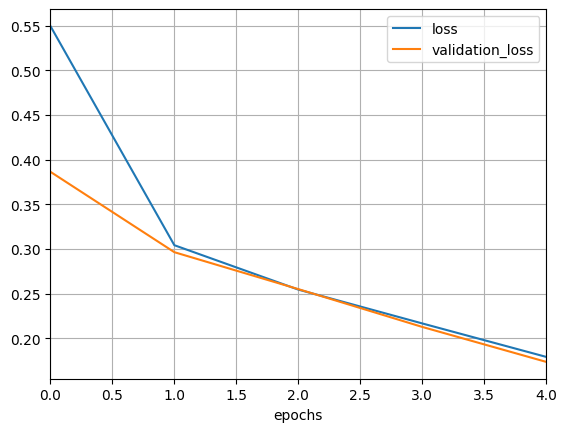

In [125]:
plot_function(history_simple_rnn)

### 1.5 Deep RNN Model

In [126]:
model_deep_rnn = Sequential()
model_deep_rnn.add(SimpleRNN(20, return_sequences = True, input_shape=[50, 1]))
model_deep_rnn.add(SimpleRNN(20, return_sequences = True))
model_deep_rnn.add(SimpleRNN(1, input_shape=[50, 1]))

In [127]:
learning_rate_deep_rnn = 0.001
optimizer_deep_rnn = Adam(learning_rate_deep_rnn)
model_deep_rnn.compile(loss='mean_squared_error', optimizer=optimizer_deep_rnn, metrics=['mean_squared_error'])

In [128]:
history_deep_rnn = model_deep_rnn.fit(X_train, y_train, epochs=no_training_epochs, validation_data=[X_valid, y_valid])

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0031 - val_mean_squared_error: 0.0031


In [129]:
score = model_deep_rnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test MSE: ', score[1])

Test loss: 0.0031492288690060377
Test MSE:  0.0031492288690060377


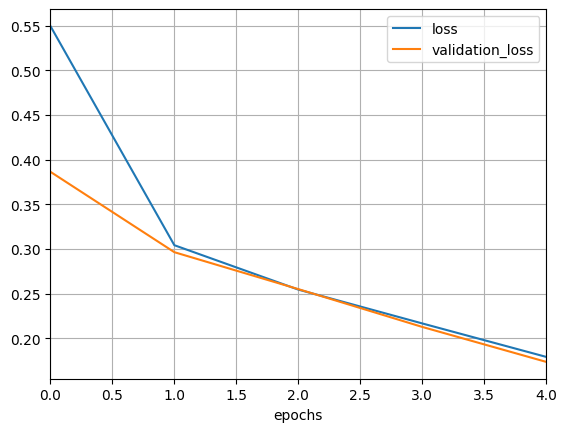

In [130]:
plot_function(history_simple_rnn)

## Exercise 2 - The movie review




Based on the written rewiev, classify if the movie if good or bad

### 2.0 - Import libraries

In [131]:
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, GRU
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.regularizers import l1, l2

### 2.1 - Load dataset

In [132]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

### 2.2 - Dataset examination

In [133]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3:word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
  id_to_word[id_] = token

In [134]:
single_sequence = " ".join([id_to_word[id_] for id_ in X_train[0][:]])

In [135]:
single_sequence # sos stands for start of the sentence

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

In [136]:
max_length = 150  # Define the maximum length of a review
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post', value=0)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post', value=0)

In [137]:
embed_size = 128
vocabulary_size = 1000

model = keras.models.Sequential([
    keras.layers.Embedding(vocabulary_size, embed_size,
                           input_shape=[None]),
    keras.layers.SimpleRNN(128, return_sequences=True),
    keras.layers.SimpleRNN(128),
    keras.layers.Dense(1, activation='sigmoid')
    ])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [138]:
optimizer = Adam(learning_rate = 0.001)

In [139]:
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [140]:
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.4990 - loss: 0.7118 - val_accuracy: 0.4938 - val_loss: 0.6952
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5058 - loss: 0.6956 - val_accuracy: 0.4938 - val_loss: 0.6934
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5007 - loss: 0.6956 - val_accuracy: 0.4926 - val_loss: 0.6932
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5007 - loss: 0.6951 - val_accuracy: 0.4938 - val_loss: 0.7036
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5083 - loss: 0.6944 - val_accuracy: 0.5004 - val_loss: 0.6939


In [141]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: ', score[1]*100, "%")

Test loss: 0.693449079990387
Test accuracy:  50.68399906158447 %


TASK: Modify structure, change the core of the network from RNN to LTSM and GRU. Compare the results

In [146]:
# RNN

embed_size = 128
vocabulary_size = 1000

model = keras.models.Sequential([
    keras.layers.Embedding(vocabulary_size, embed_size, input_shape=[None]),
    keras.layers.SimpleRNN(256, return_sequences=True),
    keras.layers.SimpleRNN(128, input_dim=100, kernel_regularizer=l2(0.01)),
    keras.layers.Dense(1, activation='sigmoid')
    ])

optimizer = Adam(learning_rate = 0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: ', score[1]*100, "%")

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.5088 - loss: 1.5127 - val_accuracy: 0.4938 - val_loss: 0.7311
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5031 - loss: 0.7151 - val_accuracy: 0.4938 - val_loss: 0.6978
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.5047 - loss: 0.7027 - val_accuracy: 0.5062 - val_loss: 0.7074
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5044 - loss: 0.7010 - val_accuracy: 0.5062 - val_loss: 0.6963
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5017 - loss: 0.6980 - val_accuracy: 0.5062 - val_loss: 0.8308
Test loss: 0.8343040347099304
Test accuracy:  50.00399947166443 %


In [147]:
# LTSM

embed_size = 128
vocabulary_size = 1000

model = keras.models.Sequential([
    keras.layers.Embedding(vocabulary_size, embed_size, input_shape=[None]),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(128, input_dim=100, kernel_regularizer=l2(0.01)),
    keras.layers.Dense(1, activation='sigmoid')
    ])

optimizer = Adam(learning_rate = 0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: ', score[1]*100, "%")

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5075 - loss: 1.2207 - val_accuracy: 0.5890 - val_loss: 0.6723
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5480 - loss: 0.6897 - val_accuracy: 0.5226 - val_loss: 0.6973
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5693 - loss: 0.6780 - val_accuracy: 0.7546 - val_loss: 0.5409
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7769 - loss: 0.5096 - val_accuracy: 0.8044 - val_loss: 0.4419
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8167 - loss: 0.4218 - val_accuracy: 0.8108 - val_loss: 0.4252
Test loss: 0.41024360060691833
Test accuracy:  81.49600028991699 %


In [148]:
# GRU

embed_size = 128
vocabulary_size = 1000

model = keras.models.Sequential([
    keras.layers.Embedding(vocabulary_size, embed_size, input_shape=[None]),
    keras.layers.GRU(256, return_sequences=True),
    keras.layers.GRU(128, input_dim=100, kernel_regularizer=l2(0.01)),
    keras.layers.Dense(1, activation='sigmoid')
    ])

optimizer = Adam(learning_rate = 0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: ', score[1]*100, "%")

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5005 - loss: 1.2034 - val_accuracy: 0.5266 - val_loss: 0.6927
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6169 - loss: 0.6477 - val_accuracy: 0.8048 - val_loss: 0.4362
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8226 - loss: 0.4053 - val_accuracy: 0.8146 - val_loss: 0.4173
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8518 - loss: 0.3490 - val_accuracy: 0.8336 - val_loss: 0.3800
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8675 - loss: 0.3135 - val_accuracy: 0.8362 - val_loss: 0.3819
Test loss: 0.3736354410648346
Test accuracy:  83.43200087547302 %


In [151]:
# GRU with LSTM

embed_size = 128
vocabulary_size = 1000

model = keras.models.Sequential([
    keras.layers.Embedding(vocabulary_size, embed_size, input_shape=[None]),
    keras.layers.GRU(256, return_sequences=True),
    keras.layers.LSTM(128, input_dim=100, kernel_regularizer=l2(0.01)),
    keras.layers.Dense(1, activation='sigmoid')
    ])

optimizer = Adam(learning_rate = 0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: ', score[1]*100, "%")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.5127 - loss: 1.2220 - val_accuracy: 0.6074 - val_loss: 0.6686
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6111 - loss: 0.6600 - val_accuracy: 0.7938 - val_loss: 0.4706
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8237 - loss: 0.4134 - val_accuracy: 0.8232 - val_loss: 0.4038
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8501 - loss: 0.4027 - val_accuracy: 0.8242 - val_loss: 0.4174
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8576 - loss: 0.3388 - val_accuracy: 0.8298 - val_loss: 0.3939
Test loss: 0.3847377300262451
Test accuracy:  83.22399854660034 %


**Test accuracy**

unchanged RNN: 50.68 %

with changed structure:


*   RNN: 50 %
*   LSTM: 81.50 %
*   GRU: 83.43 %
*   LSTM and GRU combined: 83.22 %








